In [1]:
import sys
sys.path.insert(0, '/home/disk/p/jkcm/Code')

import numpy as np
import glob
import xarray as xr
import os
import matplotlib.pyplot as plt
import datetime as dt
from tools.LoopTimer import LoopTimer
%load_ext autoreload
%autoreload 2


buuuug


In [2]:
merra_files = glob.glob(r'/home/disk/eos4/jkcm/Data/MERRA/measures/split/MERRA_unified_subset_SEP.20*.nc')
MERRA_data = xr.open_mfdataset(merra_files)

/home/disk/p/jkcm/anaconda3/envs/measures/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/disk/p/jkcm/anaconda3/envs/measures/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [ ]:
def chop_dataset(ds, list_to_keep):
    ds = ds.drop([x for x in ds.data_vars.keys() if x not in list(set([j.split(':')[0] for i in vars_to_keep for j in ds[i].dims]))+vars_to_keep])
    rename_dict = {k: k.split(':')[0] for k in list(set([j for i in vars_to_keep for j in ds[i].dims]))}
    ds = ds.rename(rename_dict)
    ds = ds.rename({"YDim": "lat", "XDim": "lon"})
    ds = ds.set_coords([i for i in rename_dict.values() if i not in ['XDim', 'YDim']] + ['lat', 'lon'])
    return ds

In [ ]:
vars_to_keep = ['Cloud_Fraction_Day_JHisto_vs_Pressure', 'Cloud_Fraction_Day_Mean', 'Cloud_Fraction_Day_Pixel_Counts']
modis_files = sorted(glob.glob(r'/home/disk/eos9/jkcm/Data/modis/MYD08/MYD08_D3.A20*.061.*.hdf'))
modis_date_strs = [i.split('MYD08_D3.A')[1][:7] for i in modis_files]
modis_dates = [dt.datetime.strptime(i, "%Y%j") + dt.timedelta(hours=12) for i in modis_date_strs]

In [ ]:
# for year in [2014, 2015, 2016][0:1]:
#     for month in np.arange(1,13)[0:1]:
#         (files, dates) = zip(*[(f, i) for (f,i) in zip(modis_files, modis_dates) if (i.year==year and i.month==month)])
#         data = xr.open_mfdataset(files, concat_dim='time', #compat='override', coords='minimal',
#                                        preprocess=lambda x: chop_dataset(x, vars_to_keep))
#         data['time'] = (('time'), list(dates))                
#         savename = f'/home/disk/eos9/jkcm/Data/modis/MYD08/nc/MYD08_D3.061.{year}-{month:02}.cloudfrac_subset.nc'
#         comp = dict(zlib=True, complevel=2)
#         data.to_netcdf(savename, engine='h5netcdf', encoding={var: comp for var in data.data_vars})


In [1]:
data = xr.open_dataset(r'/home/disk/eos9/jkcm/Data/modis/MYD08/nc/MYD08_D3.061.2014-01.cloudfrac_subset.nc')

NameError: name 'xr' is not defined

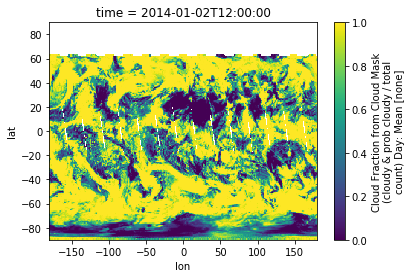

In [4]:
cf = data.Cloud_Fraction_Day_Mean.isel(time=1)
cf.plot()

In [ ]:
d = data.Cloud_Fraction_Day_JHisto_vs_Pressure#.sel(lat=-15.5, lon=84.5)
d2 = data.Cloud_Fraction_Day_Pixel_Counts#.sel(lat=-15.5, lon=84.5)
cf = data.Cloud_Fraction_Day_Mean#.sel(lat=-15.5, lon=84.5)

In [ ]:
adj_weights = np.array([list(d.CF_New_JHisto_Intervals[1:].values)+[1],list(d.CF_New_JHisto_Intervals.values)]).mean(axis=0)

In [ ]:
lc = (d.sel(CTP_New_JHisto_Intervals=slice(700,1100)).sum(dim=['CTP_New_JHisto_Intervals'])*adj_weights[None, :, None, None]).sum(
    dim='CF_New_JHisto_Intervals').values
hc = (d.sel(CTP_New_JHisto_Intervals=slice(0,700)).sum(dim=['CTP_New_JHisto_Intervals'])*adj_weights[None, :, None, None]).sum(
    dim='CF_New_JHisto_Intervals').values
pix = d2.values
new_cf = (lc+hc)/pix
low_cf = lc/(pix-hc)
high_cf = hc/pix